In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('source/FReDA3.csv')
df2 = pd.read_csv('source/FReDA4.csv')

In [3]:
# ensure ordered categorical
df2['Perception'] = pd.Categorical(
    df2['Perception'],
    categories=['Saturated', 'Satisfied', 'Deprived'],
    ordered=True
)

# reshape: one row per dyad, one column per role
wide = (
    df2
    .pivot(index='CoupleId', columns='Role', values='Perception')
    .rename(columns={
        'Anchor': 'Anchor Perception',
        'Partner': 'Partner Perception'
    })
)

# absolute counts
crosstab = pd.crosstab(
    wide['Anchor Perception'],
    wide['Partner Perception']
)

# percentages of total
crosstab_pct = pd.crosstab(
    wide['Anchor Perception'],
    wide['Partner Perception'],
    normalize='all'
) * 100

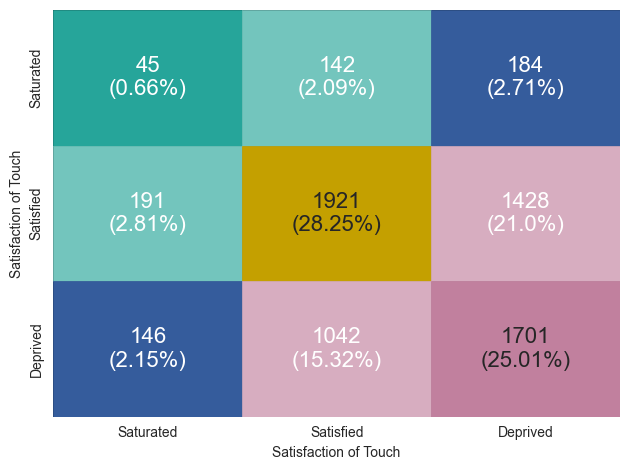

In [4]:
annot = crosstab.astype(str) + "\n(" + crosstab_pct.round(2).astype(str) + "%)"

cell_colors = np.array([
    ['#26a59a', '#73c5bd', '#355C9C'],
    ['#73c5bd', '#C4A000', '#d7adc0'],
    ['#355C9C', '#d7adc0', '#c1809e']
])

colours2 = ['#C4A000',
            '#c1809e',
            '#d7adc0',
            '#26a59a',
            '#73c5bd',
            '#355C9C']

fig, ax = plt.subplots()
sns.heatmap(
    data=crosstab,
    # annot=True,
    annot=annot,
    # fmt='d',
    fmt='',
    cbar=False,
    annot_kws={"fontsize": 16},
    linewidths=0.5,
    linecolor='black',
)
# Set the facecolor of each cell
for i in range(crosstab.shape[0]):
    for j in range(crosstab.shape[1]):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=cell_colors[i, j], edgecolor='black', lw=0.5))

plt.xlabel("Satisfaction of Touch")
plt.ylabel("Satisfaction of Touch")
plt.tight_layout()
# plt.savefig('output/img/poster/divergence3.png', dpi=600, transparent=False, bbox_inches='tight')

In [5]:
df2.loc[(df2['Kids'] == 0), "Kids binary"] = 0
df2.loc[(df2['Kids'] >= 1), "Kids binary"] = 1

couples_satisfied = df2[df2["Group3"] == "Couple Satisfaction"].copy()
couples_deprived = df2[df2["Group3"] == "Couple Deprivation"].copy()
couples_saturated = df2[df2["Group3"] == "Couple Saturation"].copy()
couples_mixed = df2[df2["Group3"] == "Couple Mixed"].copy()

In [6]:
touch_factors = [
    'Frequency',
    'Desire',
]

individual_factors = [
    'Sex',
    'Age',
    'Work Status',
    'Urbanization',
    'Education',
    'Region'

]

personality_factors = [
    'Neuroticism',
    'Extraversion',
    'Conscientiousness',
    'Openness',
    'Agreeableness',
]

wellbeing_factors = [
    'Depressiveness',
    'Loneliness',
    'Self-esteem',
    'Life Satisfaction',
    'Health',
]

relationship_factors = [
    'Relationship Length',
    'Age difference',
    'Married',
    'Cohabitation',
    'Kids',

    'Relationship Satisfaction',
    'Communication Quality',
    'Conflict Management',
]

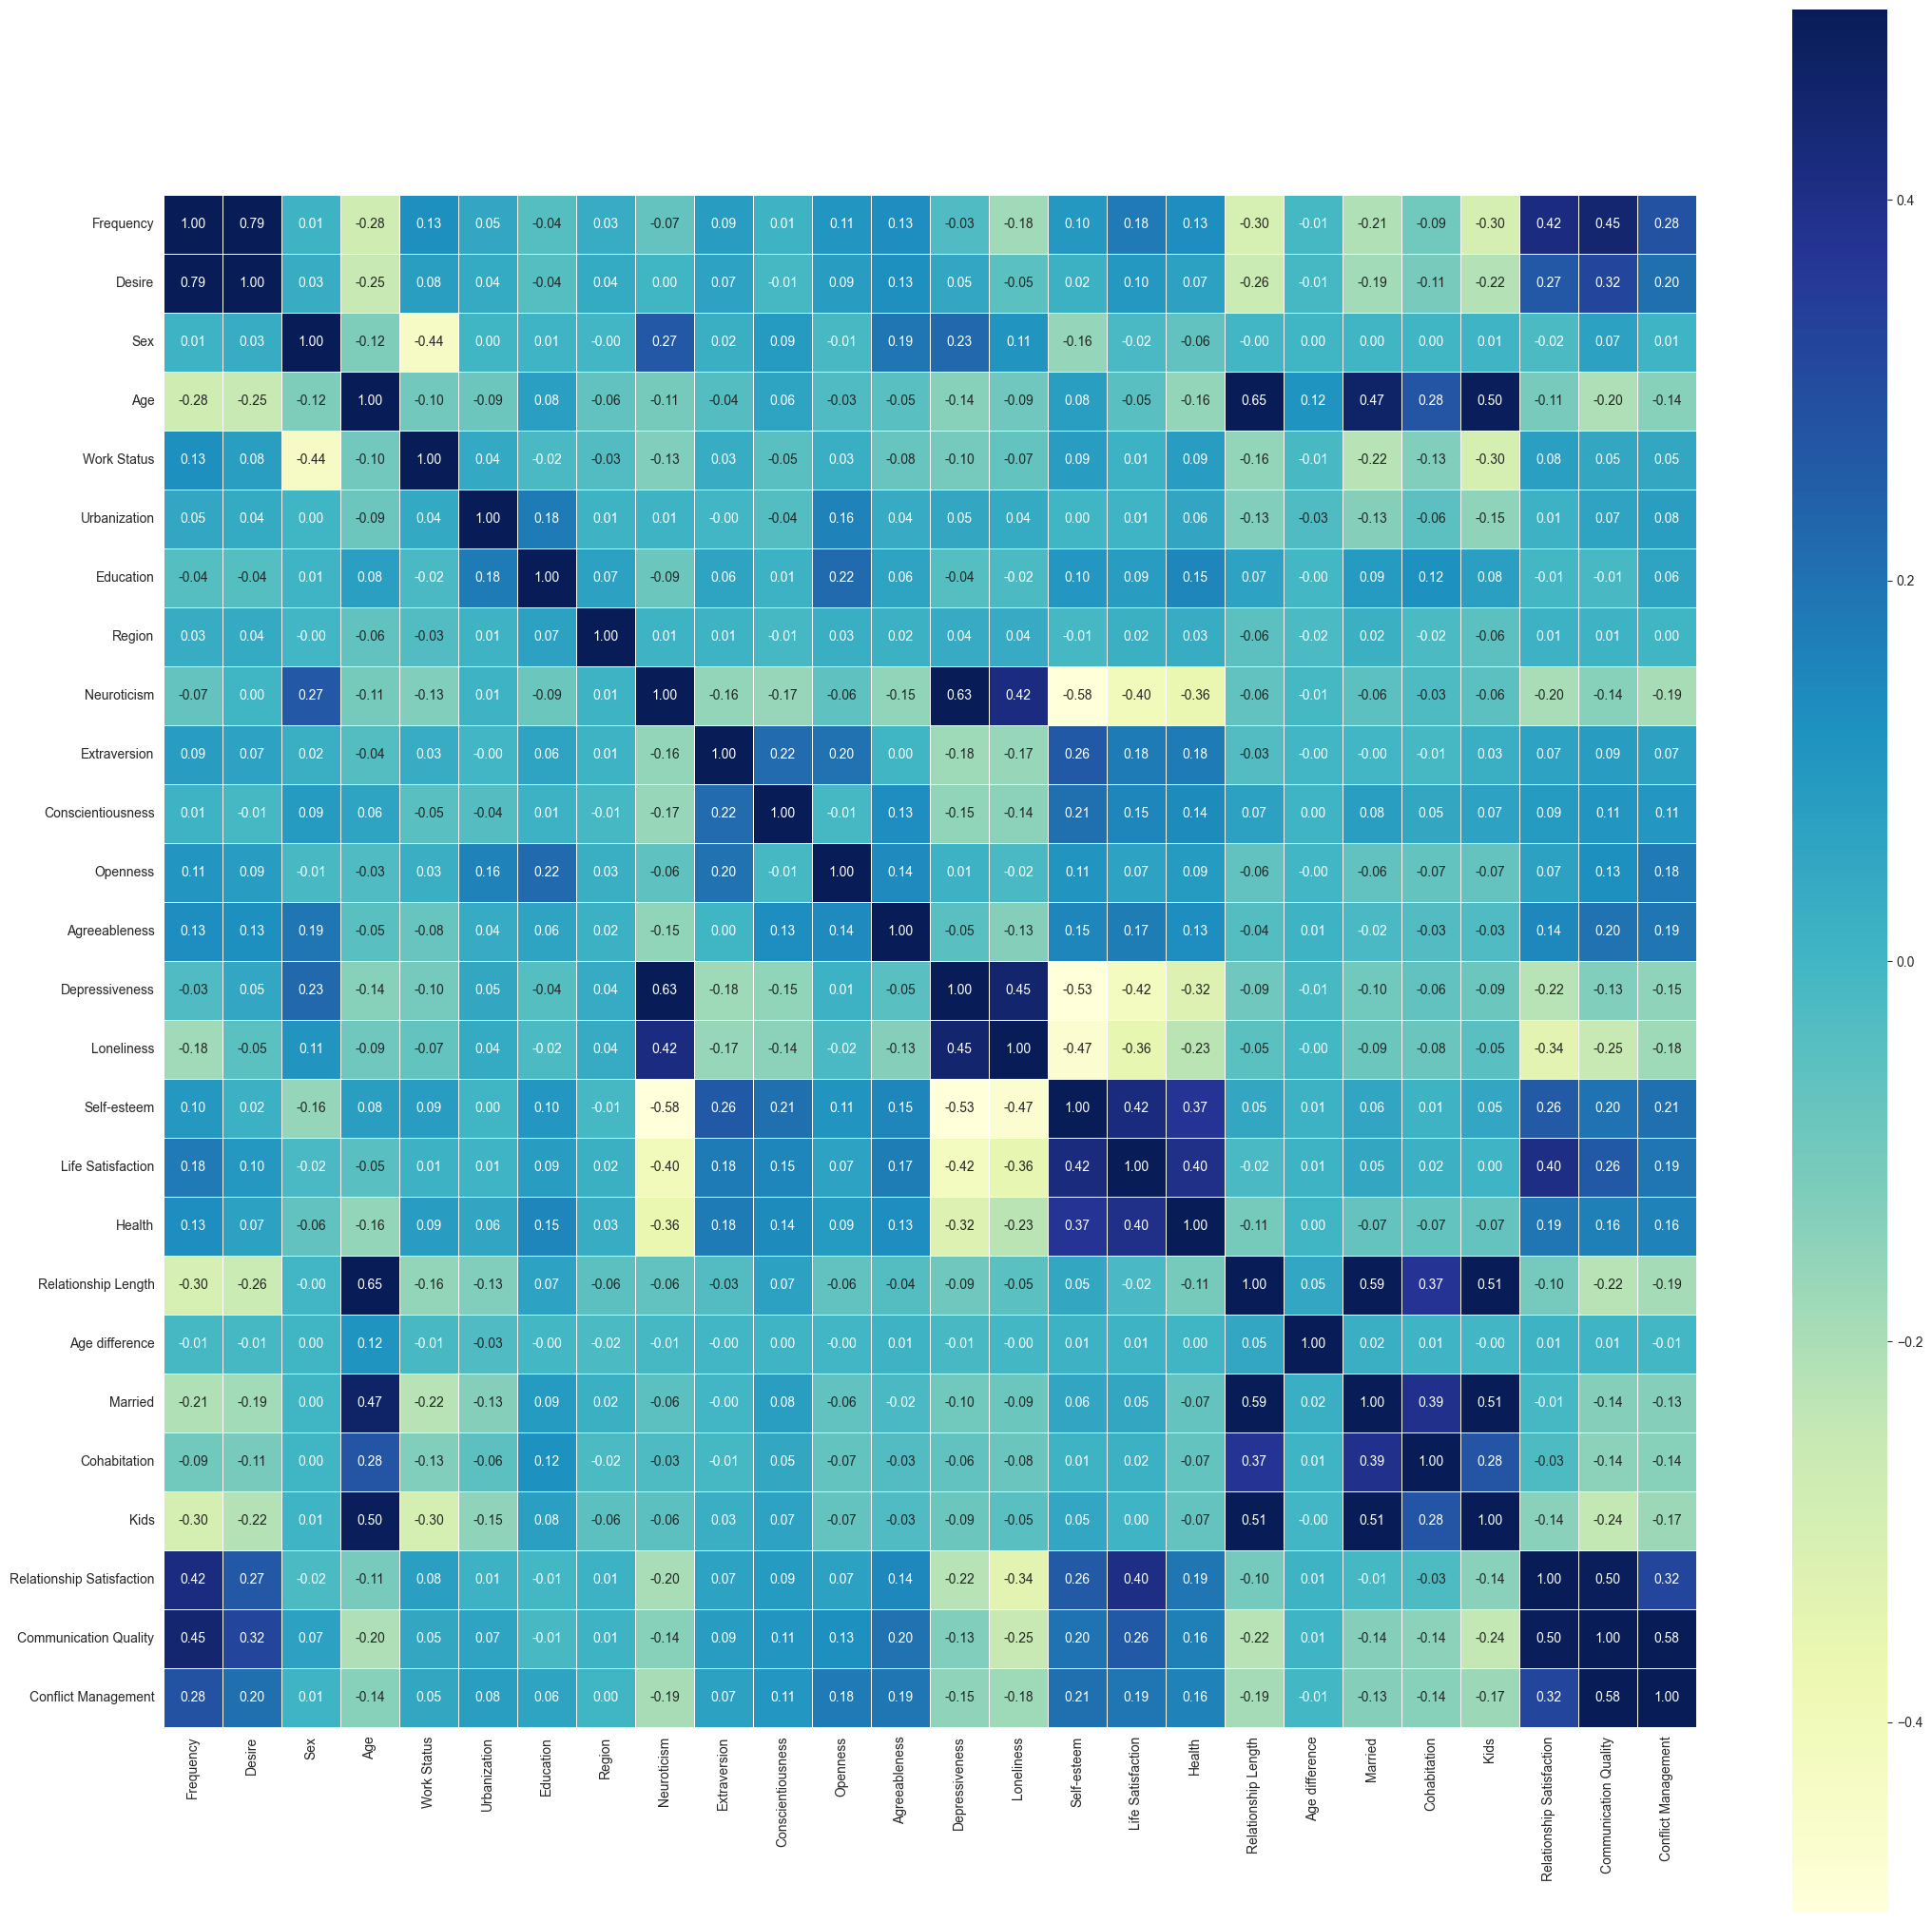

In [7]:
correlation = df2[
    touch_factors +
    individual_factors +
    personality_factors +
    wellbeing_factors +
    relationship_factors
    ].corr(method='spearman')

num_vars = len(correlation.columns)
square_size = 1  # in inches, per cell

fig_width = num_vars * square_size
fig_height = num_vars * square_size

plt.figure(figsize=(fig_width, fig_height))

sns.heatmap(correlation, cmap='YlGnBu',
            fmt='.2f',
            linewidths=0.5,
            vmax=0.5,
            vmin=-0.5,
            annot_kws={"size": 10},
            annot=True,
            square=True
            )

plt.grid(False)
# plt.savefig('output/img/poster/correlation.png', dpi=600, transparent=False, bbox_inches='tight')

cols = touch_factors + individual_factors + personality_factors + wellbeing_factors + relationship_factors

# Initialize matrices for correlation and p-values
corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
pval_matrix = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)

# Fill in the matrices
for i in range(len(cols)):
    for j in range(i, len(cols)):
        col1 = cols[i]
        col2 = cols[j]
        r, p = spearmanr(df2[col1], df2[col2], nan_policy='omit')
        corr_matrix.loc[col1, col2] = r
        corr_matrix.loc[col2, col1] = r
        pval_matrix.loc[col1, col2] = p
        pval_matrix.loc[col2, col1] = p

In [8]:
def alpha_palette(hex_color, n=7, min_alpha=0.2, max_alpha=1.0, perceptual=True):
    rgb = mcolors.to_rgb(hex_color)

    if perceptual:
        alphas = np.geomspace(min_alpha, max_alpha, n)
    else:
        alphas = np.linspace(min_alpha, max_alpha, n)

    colors_map = [(rgb[0], rgb[1], rgb[2], a) for a in alphas]
    return ListedColormap(colors_map)

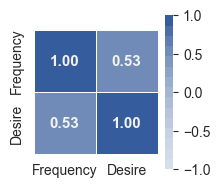

In [11]:
dfs = [couples_satisfied, couples_deprived, couples_saturated, couples_mixed]
cols = ['#C4A000',
        '#c1809e',
        '#26a59a',
        '#355C9C']

fonts = ["#222222",
         "#222222",
         "#333333",
         "#F2F2F2"]

f = 3

target_df = dfs[f]
target_col = cols[f]
target_font = fonts[f]

cmap = alpha_palette(target_col, n=15)

correlation = target_df[
    touch_factors
].corr(method='spearman')

num_vars = len(correlation.columns)
square_size = 1

fig_width = num_vars * square_size
fig_height = num_vars * square_size

plt.figure(figsize=(fig_width, fig_height))

sns.heatmap(correlation,
            cmap=cmap,
            fmt='.2f',
            linewidths=0.5,
            vmax=1,
            vmin=-1,
            annot_kws={"size": 11,
                       "fontweight": "bold",
                       "color": target_font
                       },
            annot=True,
            square=True
            )
plt.grid(False)
# plt.savefig('output/img/correlation/correlation_mix.png', dpi=600, transparent=False, bbox_inches='tight')

column = touch_factors
# Initialize matrices for correlation and p-values
corr_matrix = pd.DataFrame(np.zeros((len(column), len(column))), columns=column, index=column)
pval_matrix = pd.DataFrame(np.ones((len(column), len(column))), columns=column, index=column)

# Fill in the matrices
for i in range(len(column)):
    for j in range(i, len(column)):
        col1 = column[i]
        col2 = column[j]
        r, p = spearmanr(target_df[col1], target_df[col2], nan_policy='omit')
        corr_matrix.loc[col1, col2] = r
        corr_matrix.loc[col2, col1] = r
        pval_matrix.loc[col1, col2] = p
        pval_matrix.loc[col2, col1] = p
